In [1]:
import torch
from itertools import count
from vizdoom import gymnasium_wrapper
from matplotlib import pyplot as plt
from IPython.display import clear_output
import gymnasium
import numpy as np
import random
import math

import rlqlearning.rlqlUtil as util
import rlqlearning.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")
env = gymnasium.make("VizdoomBasic-v0")#, render_mode="human")

Running on device: cuda:0


c:\Users\killi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vizdoom\gymnasium_wrapper\base_gymnasium_env.py:84: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(


In [2]:
BATCH_SIZE = 128 # Transitions sampled from replay buffer
GAMMA = 0.99 # Discount factor
EPSILON_START = 0.9 # Start, end, and rate of decay of the epsilon value 
EPSILON_END = 0.05
EPSILON_DECAY = 1000
TAU = 0.005 # Target network update rate
LEARNING_RATE = 1e-4 # optimiser learning rate
num_actions = env.action_space.n
state, info = env.reset()
screen_w = len(state['screen'])
screen_h = len(state['screen'][0])
channels =  3
#print(screen_w)
#print(screen_h)
screen_state = torch.tensor(np.array(state['screen']), dtype=torch.float32, device=device).unsqueeze(0)

In [3]:
policy = models.DQN(screen_w, screen_h, channels, num_actions).to(device)
target = models.DQN(screen_w, screen_h, channels, num_actions).to(device)
target.load_state_dict(policy.state_dict())

optimiser = torch.optim.AdamW(policy.parameters(), lr=LEARNING_RATE, amsgrad=True)
memory = util.ReplayMemory(10000)

In [4]:
steps_done = 0
episode_durations = []
episode_scores = []
avg_scores = []
running_avg_scores =  []

def select_action(observation):
    global steps_done
    sample = random.random()
    eps_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) * \
        math.exp(-1. * steps_done / EPSILON_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy(observation.to(device)).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

Episode 42 Score: 66.0, Average: -34.58139534883721


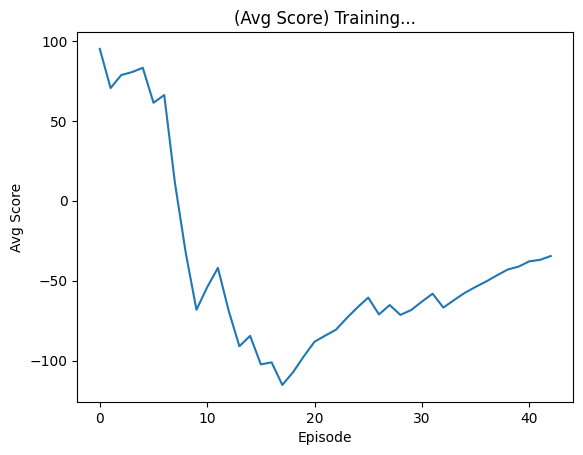

Episode 42 Score: 66.0, Running Average (3 Episodes): 54.0


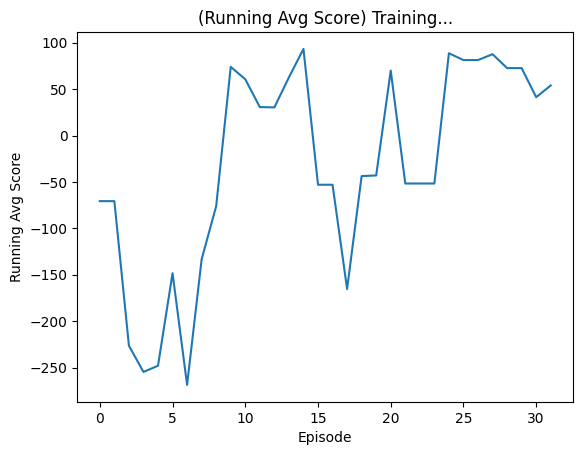

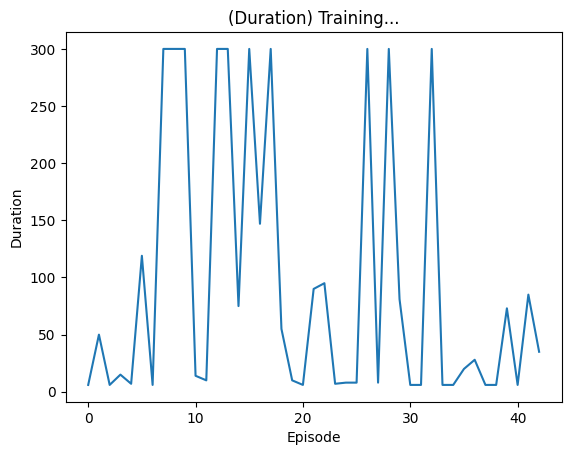

In [ ]:
if torch.cuda.is_available():
    num_episodes = 150
else:
    num_episodes = 5

for i in range(num_episodes):
    done = False
    state, info = env.reset()
    state = torch.tensor(np.array(state['screen']), dtype=torch.float32, device=device).unsqueeze(0)
    state = torch.transpose(state, 1, 3)
    score = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, info = env.step(action.item())
        score += reward
        done = terminated or truncated
        if terminated:
            next_state = None
            
            episode_scores.append(score)
            avg_scores.append((sum(episode_scores)) / (i+1))
            clear_output(wait=True)
            print(f"Episode {i} Score: {score}, Average: { (sum(episode_scores))  / (i+1) }")
            util.plot_avg_scores(avg_scores)
            
            if i > 3:
                running_avg_scores.append((sum(avg_scores[-3:]))  / 3)
                print(f"Episode {i} Score: {score}, Running Average (3 Episodes): {running_avg_scores[-1]}")
                util.plot_running_avg_scores(running_avg_scores)
            
        else:
            next_state = torch.tensor(observation['screen'], dtype=torch.float32, device=device).unsqueeze(0)
            next_state = torch.transpose(next_state, 1, 3)

        # Store the transition in memory
        #print(dir(memory))
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
        util.optimize_model(memory, policy, target, optimiser, BATCH_SIZE, GAMMA, device)
        
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_state_dict = target.state_dict()
        policy_state_dict = policy.state_dict()
        for key in policy_state_dict:
            target_state_dict[key] = policy_state_dict[key]*TAU + target_state_dict[key]*(1-TAU)
        target.load_state_dict(target_state_dict)
        
        if done:
            episode_durations.append(t + 1)
            util.plot_durations(episode_durations)
            break

print('Complete')
util.plot_durations(show_result=True)
util.plot_scores(show_result=True)
plt.ioff()
plt.show()